# Análise de Grafos - Bolsistas IC
Este notebook contém a exploração e análise dos grafos derivados da base de dados de bolsistas de iniciação científica.

In [19]:
pip install nltk

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Carregamento e Pré-Processamento

In [41]:
# ==============================================================================
# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS
# ==============================================================================
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

# Garantir que os recursos NLTK estejam disponíveis
nltk.download('stopwords')

# Carregar dataset
csv_path = 'bolsistas-iniciacao-cientificia.csv'
df = pd.read_csv(csv_path, sep=';', engine='python')

# Verificação de Duplicatas
print(f"Número de linhas duplicadas encontradas: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print("Linhas duplicadas foram removidas.")
print("-" * 50)

# --- Funções de pré-processamento ---
stem_map = {}

def preprocess_text_with_mapping(s, stem_map):
    if pd.isna(s):
        return []

    stop_words = set(stopwords.words('portuguese'))
    stemmer = RSLPStemmer()
    parts = re.split(r'[;,|/]+', str(s))

    processed_stems = []
    for p in parts:
        original_word = p.strip().lower()
        if original_word and original_word not in stop_words:
            stemmed_word = stemmer.stem(original_word)
            processed_stems.append(stemmed_word)

            # Atualiza o mapa raiz -> palavra mais comum
            if stemmed_word not in stem_map:
                stem_map[stemmed_word] = {}
            stem_map[stemmed_word][original_word] = stem_map[stemmed_word].get(original_word, 0) + 1

    return processed_stems

def get_original_word_from_stem(stem, stem_map):
    """Recupera a palavra original mais comum para exibir."""
    if stem in stem_map:
        return max(stem_map[stem], key=stem_map[stem].get)
    return stem


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Número de linhas duplicadas encontradas: 65
Linhas duplicadas foram removidas.
--------------------------------------------------


## Vizualização dos dados



In [42]:
# Carregar dataset
csv_path = 'bolsistas-iniciacao-cientificia.csv'  # ajuste o caminho se necessário
df = pd.read_csv(csv_path, sep=';', engine='python')
df.head()


,id_discente,matricula,discente,titulo,codigo_projeto,id_projeto_pesquisa,ano,id_orientador,orientador,categoria,tipo_de_bolsa,linha_pesquisa,id_grupo_pesquisa,grupo_pesquisa,cota,inicio,fim,id_unidade,unidade,status
0,739553,20170093636,ABDA ROCHA ANDRADE PINHEIRO,Pesquisando práticas musicais no contexto de N...,PVH15882-2018,129546741,2018,5751926,JEAN JOUBERT FREITAS MENDES,Iniciação Científica (IC),VOLUNTÁRIO,Processos sociais e práticas musicais na conte...,135380677.0,GPMuC - Grupo de Pesquisa Música em Múltiplos ...,2019-2020,2019/08/05 00:00:00.000000000,2020/07/31 00:00:00.000000000,284,ESCOLA DE MÚSICA - EMUFRN,PENDENTE DE RELATORIO
1,716941,2016092160,ABDÊNIO VICTOR PEREIRA DA SILVA,Nanopartículas magnéticas para oxidação avança...,PVG13574-2016,117767764,2016,22926,OSVALDO CHIAVONE FILHO,Iniciação Científica (IC),PIBIC AF CNPq,Fotoquímica e Equilíbrio de Fases,77.0,TECNOLOGIA DE TENSOATIVOS,2020-2021,2020/09/03 00:00:00.000000000,2021/08/31 00:00:00.000000000,57,DEPARTAMENTO DE ENGENHARIA QUIMICA - DEQ/CT,FINALIZADO
2,716941,2016092160,ABDÊNIO VICTOR PEREIRA DA SILVA,Nanopartículas magnéticas para oxidação avança...,PVG13574-2016,117767764,2016,22926,OSVALDO CHIAVONE FILHO,Iniciação Tecnológica (IT),PIBITI UFRN,Fotoquímica e Equilíbrio de Fases,77.0,TECNOLOGIA DE TENSOATIVOS,2020-2021,2020/08/10 00:00:00.000000000,2020/09/03 00:00:00.000000000,57,DEPARTAMENTO DE ENGENHARIA QUIMICA - DEQ/CT,FINALIZADO
3,88234,200504593,ABDON SILVA RIBEIRO DA CUNHA,ELEMENTOS DO COMPORTAMENTO ORGANIZACIONAL:Tipo...,PVE513-2008,5487590,2008,23198,WASHINGTON JOSE DE SOUSA,Iniciação Científica (IC),PIBIC,Gestão de Organizações Sociais;Trabalho Volunt...,43.0,GRUPO DE ESTUDOS E PESQUISAS EM GESTÃO INSTITU...,2008-2009,2008/11/06 00:00:00.000000000,2009/07/31 00:00:00.000000000,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS - CCSA,FINALIZADO
4,88234,200504593,ABDON SILVA RIBEIRO DA CUNHA,Geração e disseminação da inovação na carcinic...,PVE2463-2008,5554243,2008,64653,MARIANA BALDI,Iniciação Científica (IC),PIBIC,Organizações e comportamento organizacional,38.0,BASE DE ESTUDOS E PESQUISAS EM ESTRATÉGIAS E P...,2008-2009,2008/08/25 00:00:00.000000000,2008/11/06 13:35:24.877000000,161,DEPARTAMENTO DE CIÊNCIAS ADMINISTRATIVAS - DEP...,FINALIZADO


## Construção dos Grafos



In [43]:
# ==============================================================================
# 2. CONSTRUÇÃO DOS GRAFOS
# ==============================================================================
print("Construindo os grafos...")
graphs = {}

# Grafo 1: Bipartido (Discente-Orientador)
if 'discente' in df.columns and 'orientador' in df.columns:
    B_or = nx.Graph()
    discentes = df['discente'].dropna().unique()
    orientadores = df['orientador'].dropna().unique()
    B_or.add_nodes_from(discentes, bipartite=0)
    B_or.add_nodes_from(orientadores, bipartite=1)
    for _, row in df[['discente','orientador']].dropna().iterrows():
        B_or.add_edge(row['discente'], row['orientador'])
    graphs['bipartite_orientador'] = B_or

# Grafo 2: Bipartido (Discente-Unidade)
if 'discente' in df.columns and 'unidade' in df.columns:
    B_un = nx.Graph()
    discentes = df['discente'].dropna().unique()
    unidades = df['unidade'].dropna().unique()
    B_un.add_nodes_from(discentes, bipartite=0)
    B_un.add_nodes_from(unidades, bipartite=1)
    for _, row in df[['discente','unidade']].dropna().iterrows():
        B_un.add_edge(row['discente'], row['unidade'])
    graphs['bipartite_unidade'] = B_un

# Grafo 3: Coocorrência de Palavras-Chave
kw_col = 'linha_pesquisa'
if kw_col in df.columns:
    G_co = nx.Graph()
    for kws in df[kw_col].dropna():
        items = preprocess_text_with_mapping(kws, stem_map)
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                a, b = items[i], items[j]
                if G_co.has_edge(a, b):
                    G_co[a][b]['weight'] += 1
                else:
                    G_co.add_edge(a, b, weight=1)
    graphs['cooccurrence'] = G_co

print("Grafos construídos com sucesso:", list(graphs.keys()))


Construindo os grafos...
Grafos construídos com sucesso: ['bipartite_orientador', 'bipartite_unidade', 'cooccurrence']


## Métricas Básicas e Distribuição


Calculando métricas básicas dos grafos...


,graph,nodes,edges,avg_degree,density,assortativity
0,bipartite_orientador,25605,28184,2.201445,0.000086,-0.478323
1,bipartite_unidade,23524,26373,2.242221,0.000095,-0.508549
2,cooccurrence,3478,4970,2.857964,0.000822,0.028224


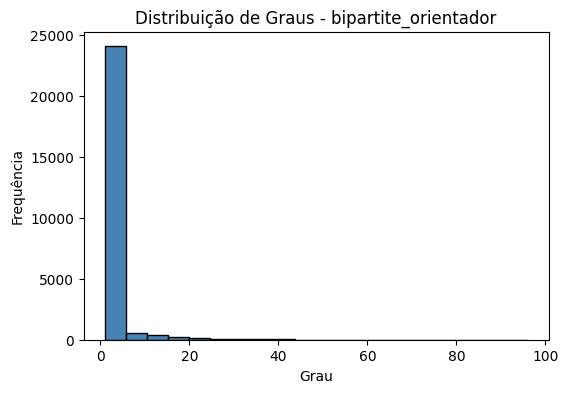

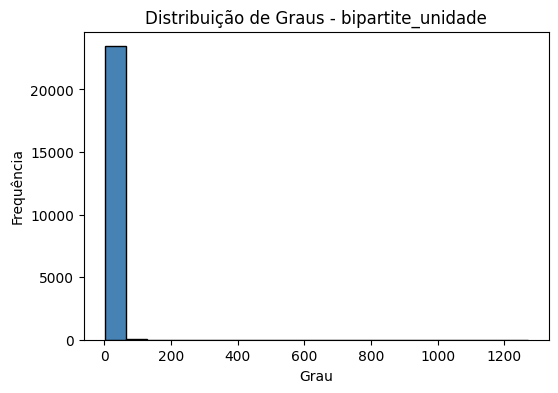

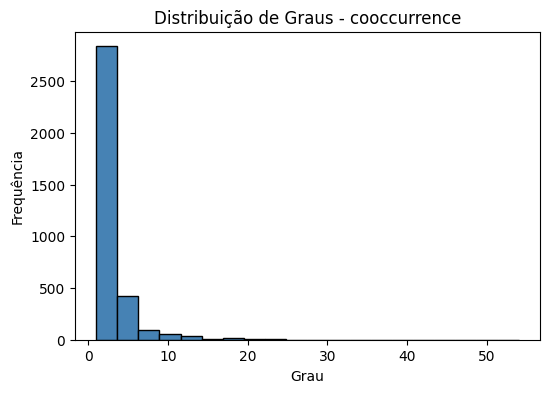

In [44]:
# ==============================================================================
# 3. ANÁLISE DE MÉTRICAS E DISTRIBUIÇÃO
# ==============================================================================
print("Calculando métricas básicas dos grafos...")
summary = []
for name, G in graphs.items():
    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_deg = sum(d for _, d in G.degree()) / n if n > 0 else 0
    dens = nx.density(G)
    assort = nx.degree_assortativity_coefficient(G) if n > 1 else 0
    summary.append({'graph': name, 'nodes': n, 'edges': m, 'avg_degree': avg_deg, 'density': dens, 'assortativity': assort})

summary_df = pd.DataFrame(summary)
display(summary_df)

# Plot: distribuição de graus
for name, G in graphs.items():
    degrees = [d for _, d in G.degree()]
    plt.figure(figsize=(6,4))
    plt.hist(degrees, bins=20, color="steelblue", edgecolor="black")
    plt.title(f"Distribuição de Graus - {name}")
    plt.xlabel("Grau")
    plt.ylabel("Frequência")
    plt.show()


## Análise de Centralidade


In [45]:
# ==============================================================================
# 4. ANÁLISE DE CENTRALIDADE
# ==============================================================================
print("Medidas de Centralidade (Top 10 nós por grau)...")
for name, G in graphs.items():
    if G.number_of_nodes() == 0: continue
    degree_centrality = nx.degree_centrality(G)
    top10 = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\n{name}:")
    for node, score in top10:
        print(f"  - {node}: {score:.3f}")


Medidas de Centralidade (Top 10 nós por grau)...

bipartite_orientador:
  - JOSE JOSEMAR DE OLIVEIRA JUNIOR: 0.004
  - ELAINE LIRA MEDEIROS: 0.003
  - CICERO FLAVIO SOARES ARAGAO: 0.003
  - GILSON DE VASCONCELOS TORRES: 0.003
  - ROBERTO DIMENSTEIN: 0.003
  - ERYVALDO SOCRATES TABOSA DO EGITO: 0.003
  - OSVALDO CHIAVONE FILHO: 0.002
  - ALINE SCHWARZ: 0.002
  - SANDRA RUFINO SANTOS: 0.002
  - LUCYMARA FASSARELLA AGNEZ LIMA: 0.002

bipartite_unidade:
  - ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ: 0.054
  - ESCOLA DE CIÊNCIAS E TECNOLOGIA - ECT: 0.042
  - FACULDADE DE CIÊNCIAS DA SAÚDE DO TRAIRI - FACISA - FACISA: 0.041
  - DEPARTAMENTO DE ENFERMAGEM - DENFER/CCS: 0.030
  - DEPARTAMENTO DE ODONTOLOGIA - DOD/CCS: 0.029
  - DEPARTAMENTO DE NUTRIÇÃO - DENUT/CCS: 0.027
  - CENTRO DE CIÊNCIAS DA SAÚDE - CCS: 0.027
  - DEPARTAMENTO DE FARMACIA - DFARM/CCS: 0.025
  - CT VICE-DIRETORIA - CT-VICEDIR: 0.025
  - PRÓ-REITORIA DE PESQUISA - PROPESQ: 0.024

cooccurrence:
  - educ: 0.016
  - meio ambi: 0.010
  

## Comunidades


In [46]:
# ==============================================================================
# 5. DETECÇÃO DE COMUNIDADES
# ==============================================================================
from networkx.algorithms import community

for name, G in graphs.items():
    if G.number_of_nodes() == 0: continue
    comms = community.greedy_modularity_communities(G)
    print(f"\n{name}: {len(comms)} comunidades detectadas.")



bipartite_orientador: 519 comunidades detectadas.

bipartite_unidade: 72 comunidades detectadas.

cooccurrence: 593 comunidades detectadas.


## Projeção de Grafos Bipartidos


In [47]:
# ==============================================================================
# 6. PROJEÇÃO DE GRAFOS BIPARTIDOS
# ==============================================================================
if 'bipartite_orientador' in graphs:
    B_or = graphs['bipartite_orientador']
    orientadores = {n for n, d in B_or.nodes(data=True) if d['bipartite'] == 1}
    advisor_graph = nx.bipartite.weighted_projected_graph(B_or, orientadores)
    print(f"\nProjeção criada: {advisor_graph.number_of_nodes()} nós e {advisor_graph.number_of_edges()} arestas.")
    graphs['advisor_collaboration'] = advisor_graph



Projeção criada: 7456 nós e 12135 arestas.


## Visualização Interativa


In [48]:
# ==============================================================================
# 7. VISUALIZAÇÃO INTERATIVA COM PLOTLY
# ==============================================================================
def plotly_network_clean_corrected(G_original, title="", bipartite_info=None, max_nodes=50):
    G = G_original.copy()
    if not G or G.number_of_nodes() == 0:
        print(f"Grafo '{title}' está vazio.")
        return

    # Subamostragem de grandes grafos
    if max_nodes and G.number_of_nodes() > max_nodes:
        if bipartite_info:
            part0_nodes, part1_nodes = bipartite_info
            part1_degrees = sorted([d for d in G.degree if d[0] in part1_nodes], key=lambda x: x[1], reverse=True)
            top_hubs = [node for node, _ in part1_degrees[:15]]
            nodes_to_keep = set(top_hubs)
            for hub in top_hubs:
                nodes_to_keep.update(G.neighbors(hub))
            G = G.subgraph(list(nodes_to_keep)).copy()
        else:
            degs = sorted(G.degree, key=lambda x: x[1], reverse=True)
            top_nodes = [node for node, _ in degs[:max_nodes]]
            G = G.subgraph(top_nodes).copy()

    pos = nx.spring_layout(G, seed=42, k=0.8)

    # Edges
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

    # Nodes
    node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        display_name = get_original_word_from_stem(node, stem_map) if 'cooccurrence' in title else node
        node_text.append(f"{display_name}<br>Grau: {G.degree(node)}")
        node_size.append(10 + G.degree(node) * 1.5)

        if bipartite_info:
            node_color.append('red' if node in bipartite_info[1] else 'blue')
        else:
            node_color.append('cornflowerblue')

    node_trace = go.Scatter(
        x=node_x, y=node_y, mode='markers', hoverinfo='text',
        marker=dict(size=node_size, color=node_color, line_width=1, line_color='black'),
        text=node_text
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'<br>{title}', showlegend=False, hovermode='closest',
                        margin=dict(b=5,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()

# Visualizar grafos principais
graph_names_to_plot = ['cooccurrence', 'bipartite_orientador', 'advisor_collaboration']

for name in graph_names_to_plot:
    if name in graphs:
        b_info = None
        if 'bipartite' in name:
            part1_nodes = {n for n, d in graphs[name].nodes(data=True) if d.get('bipartite') == 1}
            part0_nodes = set(graphs[name].nodes()) - part1_nodes
            b_info = (part0_nodes, part1_nodes)

        plotly_network_clean_corrected(graphs[name], title=f"Grafo: {name}", bipartite_info=b_info)


In [55]:
# ============================================================
# VISUALIZAÇÃO: Grafo Bipartido Discente–Unidade
# ============================================================
import networkx as nx
import plotly.graph_objects as go

# --- Parâmetros de amostragem ---
MAX_UNITS = 50              # Quantas unidades mostrar (hubs)
MAX_STUDENTS_PER_UNIT = 50 # Quantos alunos por unidade mostrar

# --- Verifica se o grafo existe ---
if 'bipartite_unidade' in graphs:
    G_original = graphs['bipartite_unidade']

    if G_original.number_of_nodes() == 0:
        print("O grafo está vazio!")
    else:
        # --- Separar conjuntos bipartidos ---
        units = {n for n, d in G_original.nodes(data=True) if d.get('bipartite') == 1}
        students = set(G_original.nodes()) - units

        # --- Selecionar top unidades pelo grau ---
        top_units = sorted(units, key=lambda u: G_original.degree(u), reverse=True)[:MAX_UNITS]

        # --- Selecionar alunos conectados a essas unidades ---
        nodes_to_keep = set(top_units)
        for u in top_units:
            neighbors = sorted(G_original.neighbors(u), key=lambda n: G_original.degree(n), reverse=True)[:MAX_STUDENTS_PER_UNIT]
            nodes_to_keep.update(neighbors)

        G = G_original.subgraph(nodes_to_keep).copy()

        # --- Layout rápido ---
        pos = nx.spring_layout(G, seed=42, k=0.5)

        # --- Traços das arestas ---
        edge_x, edge_y = [], []
        for u, v in G.edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none', mode='lines'
        )

        # --- Traços dos nós ---
        node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
        for n in G.nodes():
            x, y = pos[n]
            node_x.append(x)
            node_y.append(y)
            node_text.append(f"{n}<br>Grau: {G.degree(n)}")
            node_size.append(10 + G.degree(n) * 1.5)
            node_color.append('red' if n in units else 'blue')

        node_trace = go.Scatter(
            x=node_x, y=node_y, mode='markers',
            hoverinfo='text', text=node_text,
            marker=dict(size=node_size, color=node_color, line_width=1, line_color='black')
        )

        # --- Criar e exibir figura ---
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title=f"<br>Grafo Bipartido Discente–Unidade (Top {MAX_UNITS} Unidades)",
                            showlegend=False, hovermode='closest',
                            margin=dict(b=5, l=5, r=5, t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                        ))
        fig.show()
else:
    print("O grafo 'bipartite_unidade' não foi encontrado na variável 'graphs'.")
